In [1]:
import sys 
sys.path.append('../../../')
from src.import_packages import *
from src.visualize_EDA import vEDA

# sys.path.append('..')
# from data.custom_metric_JVowOkK import *

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, f1_score, make_scorer, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from lightgbm import LGBMClassifier, plot_importance

from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder

def predict_DL(DL_model, data, labelencoder):

    probs_ = DL_model.predict(data) 
    classes_ = np.argmax(probs_, axis=1)
    classes_tranformed_ = labelencoder.inverse_transform(classes_)

    return classes_tranformed_

def clustering_metrics(data, K = range(2, 20 + 1)):
    
    Sum_of_squared_distances = []
    Silhouette_value = []
    Calinski_Harabasz = []
    Davies_Bouldin = []

    for k in K:

        km = KMeans(n_clusters = k, n_init = 20, max_iter = 500, random_state = 20202020)
        km = km.fit(data)
        labels = km.labels_

        Sum_of_squared_distances.append(km.inertia_)
        Silhouette_value.append(silhouette_score(data, labels, metric = 'euclidean'))
        Calinski_Harabasz.append(calinski_harabasz_score(data, labels))
        Davies_Bouldin.append(davies_bouldin_score(data, labels))

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7))

    sns.pointplot(x = list(K), y = Sum_of_squared_distances, markers = 'x', s = 10, ax = ax[0, 0])
    sns.pointplot(x = list(K), y = Silhouette_value, markers = 'x', s = 10, ax = ax[1, 0])
    sns.pointplot(x = list(K), y = Calinski_Harabasz, markers = 'x', s = 10, ax = ax[0, 1])
    sns.pointplot(x = list(K), y = Davies_Bouldin, markers = 'x', s = 10, ax = ax[1, 1])

    ax[0, 0].title.set_text('Sum of squared distances ("elbow")')
    ax[1, 0].title.set_text('Silhouette value')
    ax[0, 1].title.set_text('Calinski-Harabasz')
    ax[1, 1].title.set_text('Davies-Bouldin')

    plt.show()


def return_scaled_dataframe(df, scaler = StandardScaler()):    

    df_scaled = df.copy()
    df_scaled = scaler.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns = df.columns)

    return df_scaled


def plot_clusters_with_PCA(data, K):
    
    pca = PCA(random_state = 20202020).fit(data)

    pca_plot = pd.DataFrame(pca.transform(data))[[0, 1]]
    pca_plot.columns = ['PCA_1', 'PCA_2']
    pca_plot.index = data.index
    pca_plot.reset_index(inplace = True)

    km = KMeans(n_clusters = K, n_init = 20, max_iter = 500, random_state = 20202020).fit(data)
    km = pd.DataFrame(km.predict(data), columns = ['clusters'])

    kmeans_results = pd.concat([pca_plot, km], 1)
    kmeans_results.clusters = kmeans_results.clusters.astype('object')

    fig, ax = plt.subplots(figsize = (12, 6))
    sns.scatterplot(x = 'PCA_1', y = 'PCA_2', data = kmeans_results, s = 50, hue = 'clusters', 
                    palette = sns.color_palette("Set1", kmeans_results.clusters.nunique()))
    ax.title.set_text(str(K) + ' clusters')
    ax.legend(fontsize = 'small')
    plt.show()

    return kmeans_results

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


### Meta info

In [2]:
info_static = pd.read_csv('../data/info_static.csv')
info_static.head(3)

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"


### X and y files

In [3]:
X = pd.read_csv('../data/xtrain.csv')
X_test = pd.read_csv('../data/xtest.csv')
y = pd.read_csv('../data/ytrain_NpxebDC.csv')

submission = pd.read_csv('../data/yrandom.csv')

How a submission file should look like

In [4]:
submission.head(3)

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2020-11-09T00:00:00+00:00,Offline,Available,Charging,Charging,Available,Available,Passive,Available,Charging,...,Down,Down,Available,Passive,Offline,Charging,Passive,Offline,Charging,Offline
1,2020-11-09T00:15:00+00:00,Passive,Down,Passive,Down,Charging,Passive,Down,Charging,Offline,...,Down,Down,Available,Available,Passive,Passive,Offline,Down,Down,Passive
2,2020-11-09T00:30:00+00:00,Passive,Passive,Charging,Available,Passive,Down,Available,Down,Available,...,Offline,Available,Down,Offline,Down,Charging,Available,Passive,Charging,Passive


X and y

In [5]:
X.head(3)

,timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2019-11-25T00:00:00+00:00,8.7,11.0,24.0,0.0,Fluid,218.1
1,2019-11-25T01:00:00+00:00,8.8,9.0,20.0,0.0,Fluid,144.3
2,2019-11-25T02:00:00+00:00,8.9,8.0,18.0,0.0,Fluid,110.0


In [6]:
y.head(3)

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2019-11-25T00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
1,2019-11-25T00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2,2019-11-25T00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN


X feature engineering

In [7]:
X['timestamp'] = pd.to_datetime(X['timestamp'])

X['year'] = X['timestamp'].dt.year
X['month'] = X['timestamp'].dt.month
X['day'] = pd.to_datetime(X['timestamp']).dt.day_name()
X['hour'] = X['timestamp'].dt.hour

In [8]:
X['traffic_state'].value_counts()

Fluid    8015
Busy      325
Heavy       1
Name: traffic_state, dtype: int64

In [9]:
X['traffic_state'] = X['traffic_state'].replace({'Heavy' : 'Busy'})
X = pd.get_dummies(X, columns = ['traffic_state'], prefix_sep = ' = ').drop('traffic_state = Busy', 1)

X EDA

In [10]:
X_eda = vEDA(X)

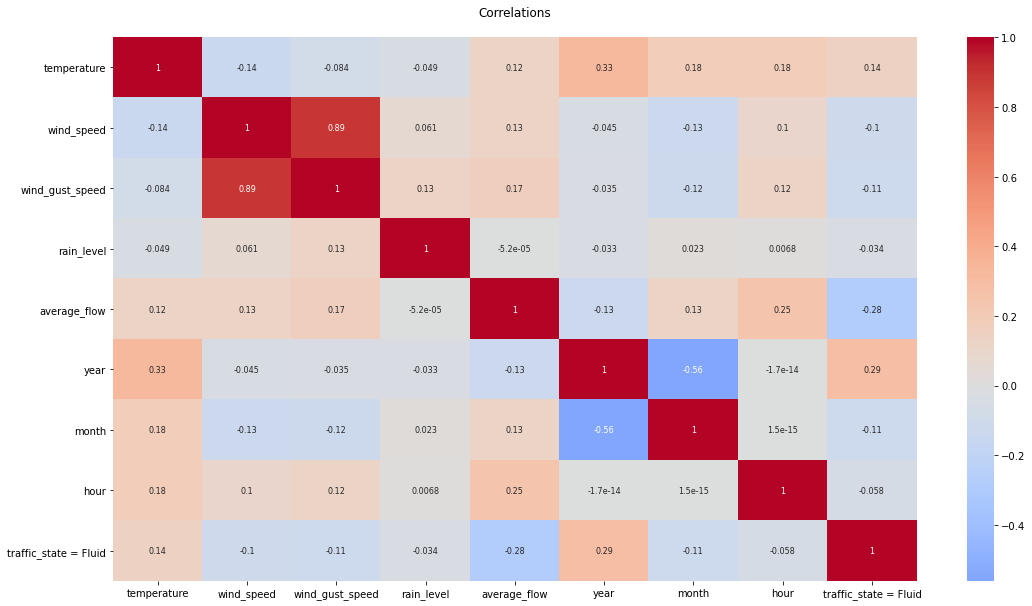

In [11]:
X_eda.plot_corr()

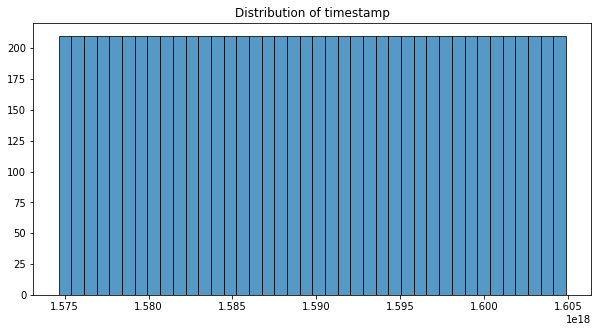

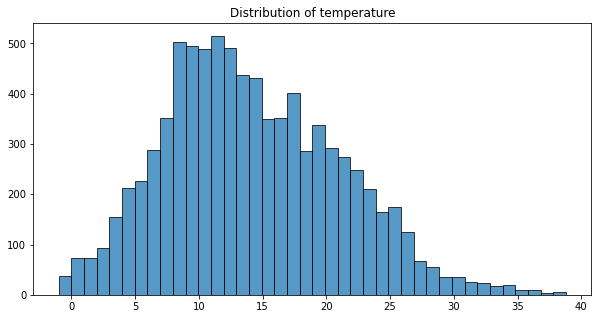

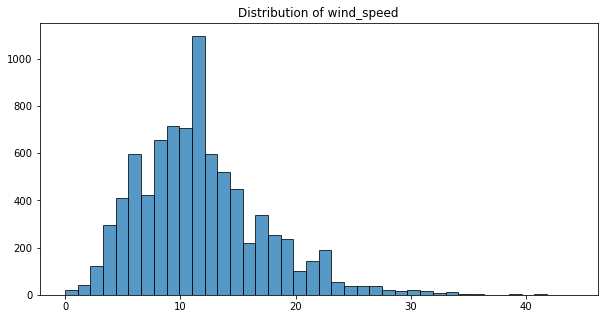

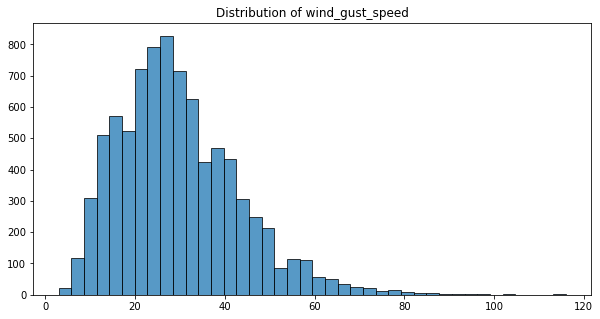

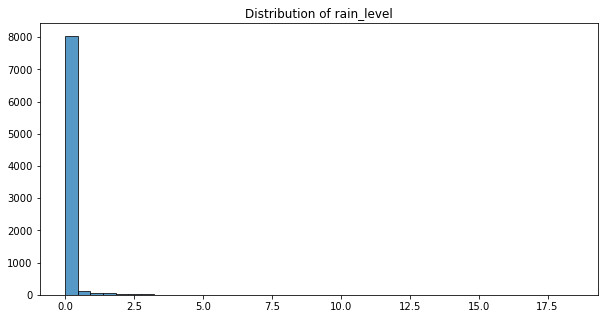

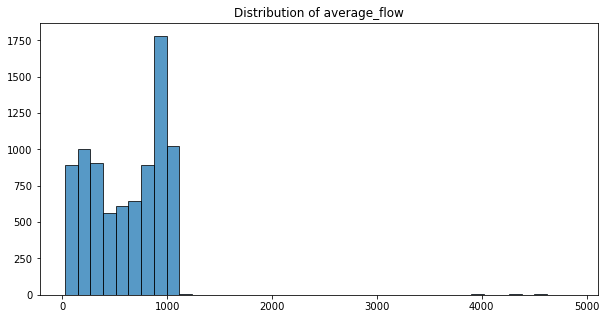

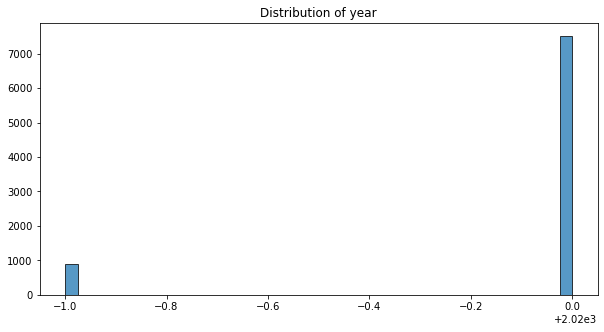

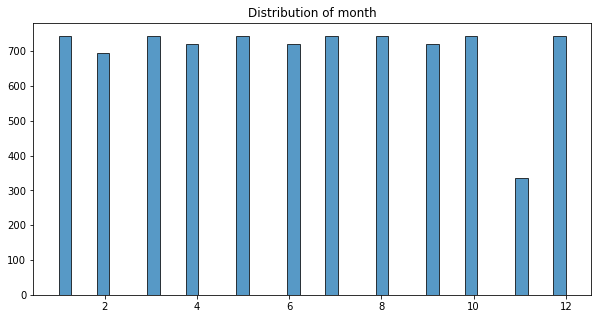

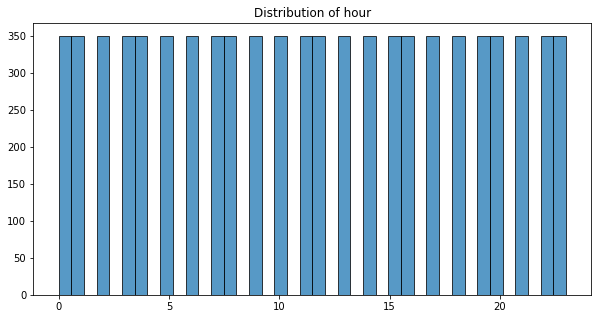

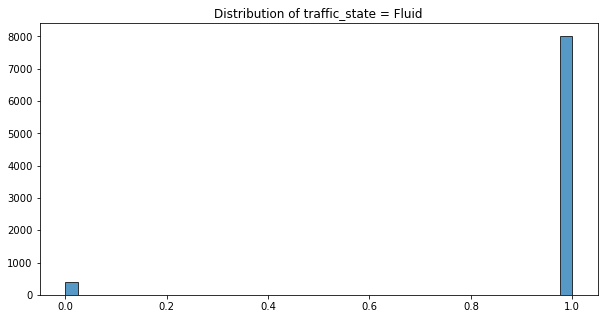

In [12]:
for i in X.select_dtypes(exclude = 'O').columns:
    X_eda.plot_dist(i)

### Capture difference across stations: use geo location

In [13]:
info_static.head(3)

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"


In [14]:
vEDA(info_static).plot_geo_map('latitude', 'longitude', zoom = 11)

In [15]:
info_static['s_id'].nunique()

91

In [16]:
info_static['s_id'].value_counts()

S84    3
S37    3
S56    3
S57    3
S75    3
      ..
S66    3
S74    3
S16    3
S67    3
S45    3
Name: s_id, Length: 91, dtype: int64

In [17]:
info_static[info_static['s_id'] == 'S63']

,t_id,s_id,latitude,longitude,street,city,zipcode,model
54,S63-T1,S63,48.870628,2.33321,7 BOULEVARD DES CAPUCINES,Paris,75002,"CHAdeMO, E/F, Combo, T2, T3"
55,S63-T3,S63,48.870628,2.33321,7 BOULEVARD DES CAPUCINES,Paris,75002,"E/F, Combo, CHAdeMO, T2, T3"
184,S63-T2,S63,48.870628,2.33321,7 BOULEVARD DES CAPUCINES,Paris,75002,E/F


In [18]:
set(', '.join(info_static['model'].to_list()).split(', '))

{'CHAdeMO', 'Combo', 'E/F', 'T2', 'T3'}

Capture station types in OHE features

In [19]:
for i in ['CHAdeMO', 'Combo', 'E/F', 'T2', 'T3']:
    col_name = 'model = ' + i
    info_static[col_name] = 0
    info_static.loc[info_static['model'].str.contains(i), col_name] = 1

In [20]:
info_static.drop('model', 1, inplace = True)

In [21]:
info_static.head(2)

,t_id,s_id,latitude,longitude,street,city,zipcode,model = CHAdeMO,model = Combo,model = E/F,model = T2,model = T3
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,1,1,1,1,1
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,1,1,1,1,1


In [22]:
info_static.filter(like = 'model').value_counts()

model = CHAdeMO  model = Combo  model = E/F  model = T2  model = T3
1                1              1            1           1             182
0                0              1            0           0              91
dtype: int64

In [23]:
info_static['model = only E/F'] = 0
info_static.loc[(info_static['model = E/F'] == 1) & (info_static['model = Combo'] == 0), 'model = only E/F'] = 1

info_static['model = all'] = 0
info_static.loc[(info_static['model = E/F'] == 1) & (info_static['model = Combo'] == 1), 'model = all'] = 1

In [24]:
info_static.drop(info_static.filter(like = 'model').columns[:-2], 1, inplace = True)

In [25]:
vEDA(info_static).plot_geo_map('latitude', 'longitude', zoom = 11, color_by='model = all', hover_name='s_id')

Calculate 'neighbor information'

- how many stations are there in a 
    - ~500m (0.05 DD)
    - 1.11km (0.01 DD)
    - 2.22km (0.02 DD)


In [26]:
station_info = info_static[['s_id', 'latitude', 'longitude']].drop_duplicates('s_id').copy()
print(station_info.shape)
station_info.set_index('s_id', inplace = True)
station_info.head(3)

(91, 3)


,latitude,longitude
s_id,,
S84,48.863766,2.411770
S86,48.890610,2.354230
S68,48.875465,2.360103


In [27]:
tree = KDTree(station_info, leaf_size = 2)

In [28]:
n05km = [i-1 for i in tree.query_radius(station_info, r = 0.005, count_only = True)]
n1km = [i-1 for i in tree.query_radius(station_info, r = 0.01, count_only = True)]
n2km = [i-1 for i in tree.query_radius(station_info, r = 0.02, count_only = True)]

station_info['neighbors_500_m'] = n05km
station_info['neighbors_1_km'] = n1km
station_info['neighbors_2_km'] = n2km

In [29]:
info_static = info_static.merge(station_info.reset_index().drop(['latitude', 'longitude'], 1), on = 's_id')

### SKIP: Try clustering terminals (y data) by finding similarly behaving ones and treating them the same

1 prediction for a cluster = all predictions for terminals in the given cluster

In [30]:
# mapper = {'Available' : 1, 'Charging' : 2, 'Passive' : 3, 'Offline' : 4, 'Down' : 5}
# y_T_cluster = y.fillna('Offline').set_index('timestamp').T.replace(mapper)

# #all(y_T_cluster.dtypes == 'int64')

# clustering_metrics(y_T_cluster, K = range(110, 120 + 1))

# y_clusters = plot_clusters_with_PCA(y_T_cluster, 2)

Optimal cluster number seems to be:
- 2: 0.5
- 45: 0.3
- 47: 0.31
- 63, 66, 68, 69: 0.32
- 83: 0.33
- 106: 0.325

Expand X with y data

In [31]:
%%time

y_transformed = y.fillna('Offline').melt(id_vars = 'timestamp', var_name = 't_id', value_name = 'target')
y_transformed = y_transformed.merge(info_static[['t_id', 'latitude', 'longitude', 'model = only E/F', 'neighbors_500_m', 'neighbors_1_km', 'neighbors_2_km']],
                                    on = 't_id')
y_transformed['timestamp'] = pd.to_datetime(y_transformed['timestamp'])
y_transformed['minute'] = y_transformed['timestamp'].dt.minute

Wall time: 22.8 s


In [32]:
y_transformed.head(2)

,timestamp,t_id,target,latitude,longitude,model = only E/F,neighbors_500_m,neighbors_1_km,neighbors_2_km,minute
0,2019-11-25 00:00:00+00:00,S7-T1,Down,48.853445,2.38688,0,0,2,10,0
1,2019-11-25 00:15:00+00:00,S7-T1,Down,48.853445,2.38688,0,0,2,10,15


In [33]:
%%time

X_y = X.merge(y_transformed, on = 'timestamp', how = 'right').fillna(method='ffill')
#X_y.drop(['t_id', 'timestamp'], 1, inplace = True)
print(X_y.shape)

(8526336, 20)
Wall time: 14.5 s


### Calculate global aggregates about stations / terminals

#### Ratio of statuses by hour-min

In [34]:
X_agg = X_y.groupby(['t_id', 'hour', 'minute', 'target']).agg({'temperature' : 'count'}).reset_index()
X_agg_total = X_y.groupby(['t_id', 'hour', 'minute']).agg({'wind_speed' : 'count'}).reset_index()

X_agg = X_agg.merge(X_agg_total, on = ['t_id', 'hour', 'minute'])
X_agg['ratios'] = X_agg['temperature'] / X_agg['wind_speed']
X_agg.drop(['temperature', 'wind_speed'], 1, inplace = True)

X_agg = X_agg.pivot_table(index = ['t_id', 'hour', 'minute'], columns = 'target', values = 'ratios').reset_index().fillna(0)

X_agg.columns = ['t_id', 'hour', 'minute', 'Ratio of Available HOURMIN', 'Ratio of Charging HOURMIN', 
                'Ratio of Down HOURMIN',  'Ratio of Offline HOURMIN', 'Ratio of Passive HOURMIN']

In [35]:
X_y = X_y.merge(X_agg, on = ['t_id', 'hour', 'minute'])

#### Ratio of statuses by weekday - hour

In [36]:
X_agg_DH = X_y.groupby(['t_id', 'day', 'hour', 'target']).agg({'temperature' : 'count'}).reset_index()
X_agg_DH_total = X_y.groupby(['t_id', 'day', 'hour']).agg({'wind_speed' : 'count'}).reset_index()

X_agg_DH = X_agg_DH.merge(X_agg_DH_total, on = ['t_id', 'day', 'hour'])
X_agg_DH['ratios'] = X_agg_DH['temperature'] / X_agg_DH['wind_speed']
X_agg_DH.drop(['temperature', 'wind_speed'], 1, inplace = True)

X_agg_DH = X_agg_DH.pivot_table(index = ['t_id', 'day', 'hour'], columns = 'target', values = 'ratios').reset_index().fillna(0)

X_agg_DH.columns = ['t_id', 'day', 'hour', 'Ratio of Available DAYHOUR', 'Ratio of Charging DAYHOUR', 
                'Ratio of Down DAYHOUR',  'Ratio of Offline DAYHOUR', 'Ratio of Passive DAYHOUR']

In [37]:
X_y = X_y.merge(X_agg_DH, on = ['t_id', 'day', 'hour'])

#### Ratio of statuses month - weekday

In [38]:
X_agg_MD = X_y.groupby(['t_id', 'month', 'day', 'target']).agg({'temperature' : 'count'}).reset_index()
X_agg_MD_total = X_y.groupby(['t_id', 'month', 'day']).agg({'wind_speed' : 'count'}).reset_index()

X_agg_MD = X_agg_MD.merge(X_agg_MD_total, on = ['t_id', 'month', 'day'])
X_agg_MD['ratios'] = X_agg_MD['temperature'] / X_agg_MD['wind_speed']
X_agg_MD.drop(['temperature', 'wind_speed'], 1, inplace = True)

X_agg_MD = X_agg_MD.pivot_table(index = ['t_id', 'month', 'day'], columns = 'target', values = 'ratios').reset_index().fillna(0)

X_agg_MD.columns = ['t_id', 'month', 'day', 'Ratio of Available MONTHDAY', 'Ratio of Charging MONTHDAY', 
                'Ratio of Down MONTHDAY',  'Ratio of Offline MONTHDAY', 'Ratio of Passive MONTHDAY']

In [39]:
X_y = X_y.merge(X_agg_MD, on = ['t_id', 'month', 'day'])

In [40]:
X_y.drop(['timestamp', 't_id'], 1, inplace = True)

In [41]:
X_y.head(3)

,temperature,wind_speed,wind_gust_speed,rain_level,average_flow,year,month,day,hour,traffic_state = Fluid,...,Ratio of Available DAYHOUR,Ratio of Charging DAYHOUR,Ratio of Down DAYHOUR,Ratio of Offline DAYHOUR,Ratio of Passive DAYHOUR,Ratio of Available MONTHDAY,Ratio of Charging MONTHDAY,Ratio of Down MONTHDAY,Ratio of Offline MONTHDAY,Ratio of Passive MONTHDAY
0,8.7,11.0,24.0,0.0,218.1,2019.0,11.0,Monday,0.0,1.0,...,0.0,0.0,0.976744,0.023256,0.0,0.0,0.0,0.507937,0.492063,0.0
1,18.4,23.0,53.0,0.0,74.1,2020.0,11.0,Monday,0.0,1.0,...,0.0,0.0,0.976744,0.023256,0.0,0.0,0.0,0.507937,0.492063,0.0
2,8.7,11.0,24.0,0.0,218.1,2019.0,11.0,Monday,0.0,1.0,...,0.0,0.0,0.976744,0.023256,0.0,0.0,0.0,0.507937,0.492063,0.0


Check correlation between created agg features

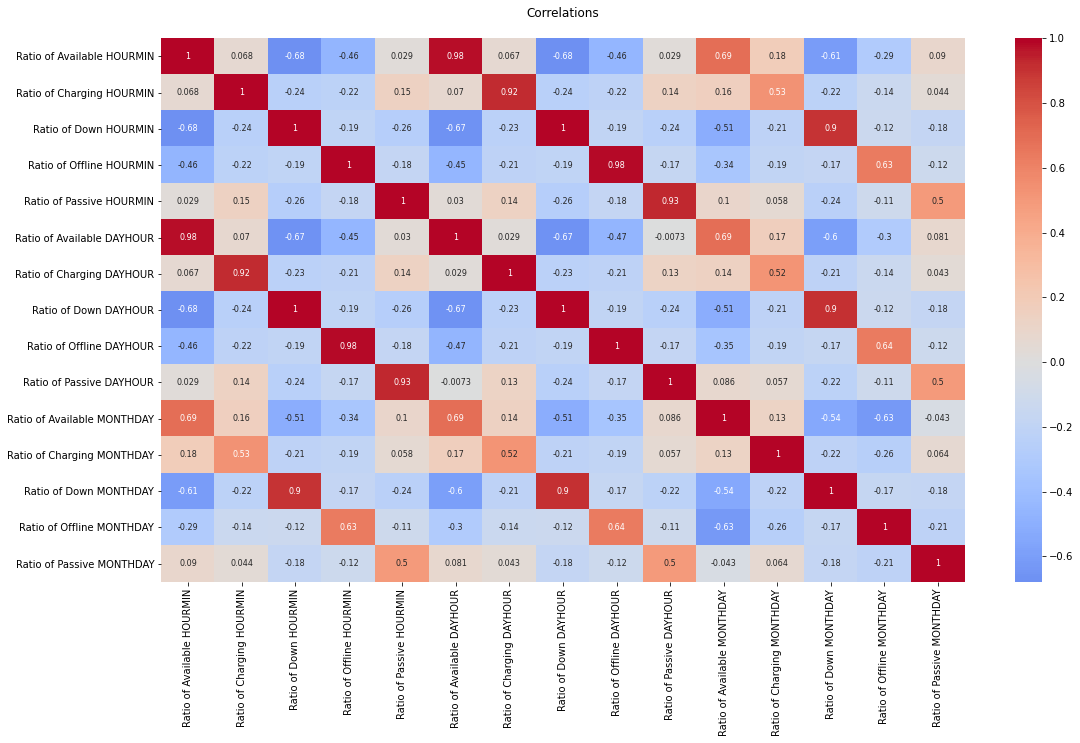

In [42]:
vEDA(X_y).plot_corr(numerics = X_y.filter(like = 'Ratio').columns)

For memory and time purposes, undersample X_y and train on less data 

In [43]:
# X_y_sample = X_y.sample(random_state = 975, n = 10000)
X_y_sample = X_y.groupby(['target', 'month']).sample(n = 1000, random_state = 975)

In [44]:
print(X_y.shape)
print(X_y_sample.shape)

(8526336, 33)
(60000, 33)


In [45]:
del X_y

## Apply ML models

In [46]:
def evaluate_macroF1_lgb(truth, predictions):  

    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    
    return ('macroF1', f1, True) 

f1 = make_scorer(f1_score, average = 'weighted')

In [47]:
X = X_y_sample.drop('target', 1).copy()
X = pd.get_dummies(X, columns = ['day'], drop_first=True)

Y = X_y_sample['target'].copy()

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size = .75, random_state = 975)

In [49]:
%%time

lgb = LGBMClassifier(n_jobs=-1, objective='multiclass', random_state=975, colsample_bytree = 1/2)
lgb.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose = 0,
        eval_metric = evaluate_macroF1_lgb, early_stopping_rounds = 20)

Wall time: 11.4 s


LGBMClassifier(colsample_bytree=0.5, objective='multiclass', random_state=975)

### Grid search

In [50]:
%%time

LGB_params = {'boosting_type' : 'gbdt',
              'learning_rate' : 0.1,
              'num_leaves' : 25,
              'min_child_samples' : 5,
              'max_depth' : 17,
              'colsample_bytree' : 0.7,
              'n_estimators' : 200}

LGB = LGBMClassifier(random_state = 975, objective = 'multiclass', n_jobs = -1, **LGB_params)
LGB.fit(X_train, y_train)

#GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = f1, n_jobs = -1)
#GRID_LGB.fit(X_train, y_train)

Wall time: 16.3 s


LGBMClassifier(colsample_bytree=0.7, max_depth=17, min_child_samples=5,
               n_estimators=200, num_leaves=25, objective='multiclass',
               random_state=975)

In [51]:
%%time
predictions = LGB.predict(X_valid)
print(classification_report(y_valid, predictions, digits = 4))

              precision    recall  f1-score   support

   Available     0.7005    0.4761    0.5669      3016
    Charging     0.6239    0.7348    0.6748      2926
        Down     0.9361    0.9699    0.9527      3053
     Offline     0.7608    0.8222    0.7903      2947
     Passive     0.6930    0.7152    0.7039      3058

    accuracy                         0.7438     15000
   macro avg     0.7429    0.7436    0.7377     15000
weighted avg     0.7438    0.7438    0.7383     15000

Wall time: 1.53 s


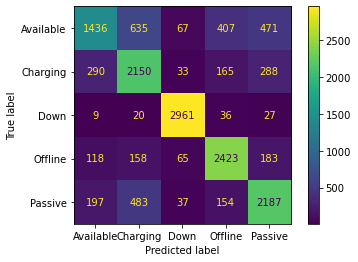

In [52]:
plot_confusion_matrix(LGB, X_valid, y_valid)
plt.show()

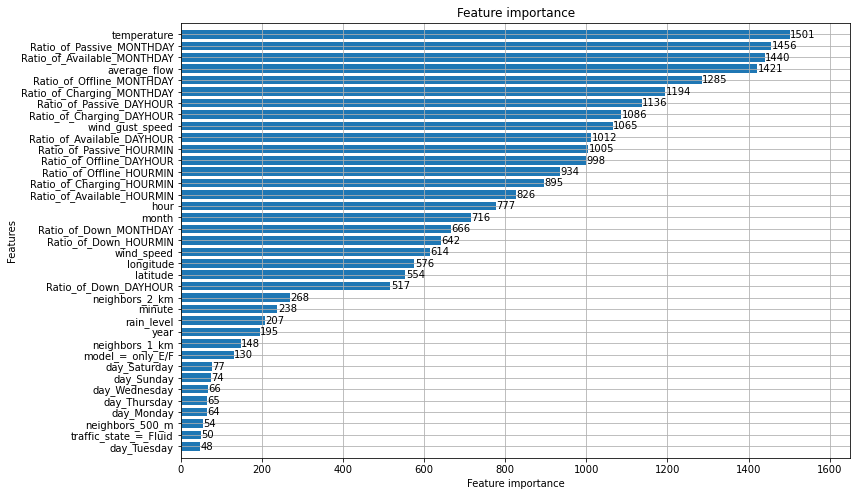

In [53]:
plot_importance(LGB, height = .75, figsize = (12, 8))
plt.show()

## Try Neural Network approach

Encode target via OHE

In [63]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_DL = encoder.transform(y_train)
y_valid_DL = encoder.transform(y_valid)

# convert integers to dummy variables (i.e. one hot encoded)
y_train_DL = np_utils.to_categorical(y_train_DL)
y_valid_DL = np_utils.to_categorical(y_valid_DL)

Scale X

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_DL = scaler.transform(X_train)
X_valid_DL = scaler.transform(X_valid)

Build DL model

In [111]:
model = Sequential(name = 'EV_DL_Predictor')

model.add(Dense(32, input_dim = X_train_DL.shape[1], activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(encoder.classes_), activation='softmax'))

# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

In [112]:
model.summary()

Model: "EV_DL_Predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                1216      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)             

Train DL model

In [113]:
callbacks = [PlotLossesKeras(),
             EarlyStopping(monitor = 'val_loss', patience = 10),
             ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 1/2)]

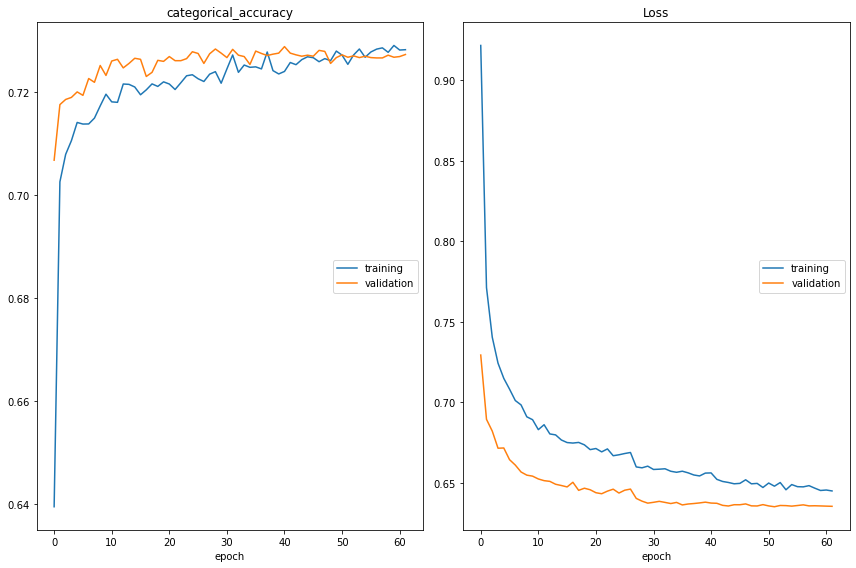

categorical_accuracy
	training         	 (min:    0.639, max:    0.729, cur:    0.728)
	validation       	 (min:    0.707, max:    0.729, cur:    0.727)
Loss
	training         	 (min:    0.645, max:    0.922, cur:    0.645)
	validation       	 (min:    0.635, max:    0.729, cur:    0.635)


In [114]:
model.fit(X_train_DL, y_train_DL, batch_size = 64, epochs = 100, validation_data = (X_valid_DL, y_valid_DL),
          verbose = 1,callbacks = callbacks)

Make predictions and evaluate

In [121]:
DL_predictions_classes = predict_DL(model, X_valid_DL, encoder)

In [122]:
print(classification_report(y_valid, DL_predictions_classes, digits = 4))

              precision    recall  f1-score   support

   Available     0.7033    0.4261    0.5307      3016
    Charging     0.5991    0.7139    0.6515      2926
        Down     0.9230    0.9741    0.9479      3053
     Offline     0.7301    0.8300    0.7769      2947
     Passive     0.6792    0.6916    0.6854      3058

    accuracy                         0.7273     15000
   macro avg     0.7270    0.7272    0.7185     15000
weighted avg     0.7281    0.7273    0.7191     15000



### Create submission file

#### Run X_test thru processing steps

In [117]:
def process_X(data, submission_example, DL = False):

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = pd.to_datetime(data['timestamp']).dt.day_name()
    data['hour'] = data['timestamp'].dt.hour

    data['traffic_state'] = data['traffic_state'].replace({'Heavy' : 'Busy'})
    data = pd.get_dummies(data, columns = ['traffic_state'], prefix_sep = ' = ')#.drop('traffic_state = Busy', 1)

    # X test has some NaNs in weather-like features
    # impute by taking rolling mean (need 81 as there are ranges of NaNs with 81)
    data = data.fillna(data.rolling(81, min_periods = 1).mean())

    # expand Y with info about terminals (location, neighbors)

    submission_example = submission_example.fillna('Offline').melt(id_vars = 'timestamp', var_name = 't_id', value_name = 'target')
    submission_example = submission_example.merge(info_static[['t_id', 'latitude', 'longitude', 'model = only E/F', 'neighbors_500_m', 'neighbors_1_km', 'neighbors_2_km']],
                                        on = 't_id')
    submission_example['timestamp'] = pd.to_datetime(submission_example['timestamp'])
    submission_example['minute'] = submission_example['timestamp'].dt.minute
    
    TS_and_TERMINAL_INFO = submission_example[['timestamp', 't_id']].copy()
    submission_example.drop(['target'], 1, inplace = True)    

    data = data.merge(submission_example, on = 'timestamp', how = 'right').fillna(method='ffill')
    data.drop('timestamp', 1, inplace = True)

    # add agg data
    data = data.merge(X_agg, on = ['t_id', 'hour', 'minute'])
    data = data.merge(X_agg_DH, on = ['t_id', 'day', 'hour'])
    data = data.merge(X_agg_MD, on = ['t_id', 'month', 'day'])

    data.drop(['t_id'], 1, inplace = True)

    data = pd.get_dummies(data, columns = ['day'], drop_first=True)

    # if DL

    if DL:
        data = scaler.transform(data)


    return data, TS_and_TERMINAL_INFO

In [193]:
X_test_processed, TS_and_TERMINAL_INFO = process_X(X_test, submission)

In [118]:
X_test_processed_DL, TS_and_TERMINAL_INFO = process_X(X_test, submission, DL = True)

#### Predict on test set

In [194]:
test_predictions = LGB.predict(X_test_processed)

In [124]:
test_predictions_DL = predict_DL(model, X_test_processed_DL, encoder)

#### Create submission file (LGB)

In [195]:
submission_col_order = submission.columns

submit_file = TS_and_TERMINAL_INFO.copy() 
submit_file['predicted_target'] = test_predictions
submit_file['timestamp'] = submit_file['timestamp'].astype('O')

submit_file_pivoted = submit_file.pivot_table(index = 'timestamp', columns = 't_id', values = 'predicted_target', aggfunc = 'first').reset_index()
submit_file_pivoted.columns = submission_col_order

submit_file_pivoted['timestamp'] = submission['timestamp']

In [200]:
submit_file_pivoted.to_csv('../data/SUBMISSION_BASELINE_ADD_MINUTES_ADD_AGG.csv', index = False)

#### Create submission file (DL)

In [126]:
submission_col_order = submission.columns

submit_file = TS_and_TERMINAL_INFO.copy() 
submit_file['predicted_target'] = test_predictions_DL
submit_file['timestamp'] = submit_file['timestamp'].astype('O')

submit_file_pivoted = submit_file.pivot_table(index = 'timestamp', columns = 't_id', values = 'predicted_target', aggfunc = 'first').reset_index()
submit_file_pivoted.columns = submission_col_order

submit_file_pivoted['timestamp'] = submission['timestamp']

In [128]:
submit_file_pivoted.to_csv('../data/SUBMISSION_DL.csv', index = False)